In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import galsim
import jiffy

scale = 0.2 # arcseconds

1. Loop over fields
2. Loop over galaxies in a field
3. Load the image data
4. Load the truth catalog
5. Instantiate the Roaster model
6. Set the Roaster parameters from the truth catalog
7. Evaluate the conditional posterior of one shear component
8. Calculate shear estimator bias and variance
9. Aggregate results for all fields and infer (m, c)

In [2]:
def load_footprint(ifield, igal):
    infile = "control/ground/constant/segments/seg_{:0>3}.h5".format(ifield)
    hfile = h5py.File(infile, 'r')
    img = hfile['Footprints/seg{:d}/lsst/r/epoch_0/image'.format(igal)][...]
    noise_var = hfile['Footprints/seg{:d}/lsst/r/epoch_0/noise'.format(igal)][...]
#     print "noise_var:", noise_var
#     print "noise_var: {:3.2e}".format(noise_var)
    hfile.close()
    return img

def get_truths(ifield, igal):
    """
    Get the true parameter values
    """
    topdir = "control/ground/constant"
    infile = os.path.join(topdir, 
                          "epoch_catalog-{0:0>3}-0.fits".format(ifield))
    hdulist = fits.open(infile)
    tbdata = hdulist[1].data
    shears = [tbdata.field('g1')[0], tbdata.field('g2')[0]]
    # Convert offsets in the truth catalog from pixels to arcseconds 
    # (which are the units expected by the galsim shift() method)
    gal_params = np.array([tbdata.field('dx')[igal], tbdata.field('dy')[igal]]) * scale
    return shears, gal_params

def ln_gaus(xval, ln_amp, x_mean, sigma):
    """
    Evaluate the log of a Gaussian density function (unnormalized)
    """
    return ln_amp - 0.5 * (xval - x_mean)**2 / sigma**2

def ln_gaus_2d((x, y), ln_amp, xo, yo, sigma_x, sigma_y, theta):
    """
    Evaluate the log of a 2D Gaussian density function (unnormalized)\
    
    http://stackoverflow.com/a/21566831/4907
    """
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = ln_amp - 0.5 * (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2))
    return g.ravel()

def fit_gaussian(dat_x, dat_y):
    """
    Fit a 1D Gaussian to input data
    """
    from scipy.optimize import curve_fit

    # ln_amp, x0, y0, sigma_x, sigma_y, theta
    params = [-2000, 0., 0., 0.001, 0.001, 0.0]

    popt, pcov = curve_fit(ln_gaus_2d, dat_x, dat_y.ravel(), p0=params)
    return popt, pcov

In [3]:
hdulist = fits.open("control/ground/constant/epoch_catalog-000-0.fits")
tbdata = hdulist[1].data

In [4]:
tbdata

FITS_rec([ (0,  24.5,  24.5, -0.98060579, -0.41024529,  0.,  0.,  0.6,  0.00281564, -0.08238713,  0.,  0.),
       (1,  72.5,  24.5,  0.69041946, -0.12537876,  0.,  0.,  0.6,  0.00281564, -0.08238713,  0.,  0.),
       (2,  24.5,  72.5, -0.09994826,  0.0568242 ,  0.,  0.,  0.6,  0.00281564, -0.08238713,  0.,  0.),
       (3,  72.5,  72.5,  0.64106718,  0.80819726,  0.,  0.,  0.6,  0.00281564, -0.08238713,  0.,  0.)], 
      dtype=(numpy.record, [('num', '>i4'), ('x', '>f8'), ('y', '>f8'), ('dx', '>f8'), ('dy', '>f8'), ('psf_e1', '>f8'), ('psf_e2', '>f8'), ('psf_fwhm', '>f8'), ('g1', '>f8'), ('g2', '>f8'), ('gal_e1', '>f8'), ('gal_e2', '>f8')]))

In [5]:
nfields = 50
ngals_per_field = 4

nx = ny = 48

# fig = plt.figure(figsize=(10, 10))

# Columns: (b1, sigma1, b2, sigma2)
bias = np.zeros((nfields, 4), dtype=np.float64)
g_true = np.zeros((nfields, 2), dtype=np.float64)
for ifield in xrange(nfields):
    print "--- Field {:d} / {:d} ---".format(ifield+1, nfields)
    for igal in xrange(ngals_per_field):
        img = load_footprint(ifield, igal)
        true_shears, true_params = get_truths(ifield, igal)
        # -----
        rstr = jiffy.Roaster("jiffy_bt1.yaml")
        rstr.ngrid_x = nx
        rstr.ngrid_y = ny
        rstr.src_models[0].params[0].dx = true_params[0]
        rstr.src_models[0].params[0].dy = true_params[1]
        rstr.src_models[0].set_params(true_shears)
        rstr.data = img
#         print rstr.src_models[0].params
        # -----
#         model = rstr._get_model_image()
#         plt.subplot(2, 2, igal+1)
#         plt.imshow(rstr.data - model.array)
#         plt.colorbar()
        # -----
        g_true[ifield, 0] = true_shears[0]
        g_true[ifield, 1] = true_shears[1]
        ngg = 15
        shear1 = np.linspace(true_shears[0] - 0.02, true_shears[0] + 0.02, ngg)
        shear2 = np.linspace(true_shears[1] - 0.02, true_shears[1] + 0.02, ngg)
        g1, g2 = np.meshgrid(shear1, shear2)

        lnp = np.zeros((ngg, ngg), dtype=np.float64)
        for i in xrange(ngg):
            for j in xrange(ngg):
                lnp[i,j] = rstr([g1[i,j], g2[i,j]])
        # -----
#         plt.subplot(2, 2, igal+1)
#         plt.imshow(lnp, interpolation='none', cmap=plt.cm.viridis)
#         plt.colorbar()
        # -----
        popt, _ = fit_gaussian((g1, g2), lnp)
#         print popt
        bias[ifield, 0] += popt[1] - true_shears[0]
        bias[ifield, 1] += popt[3]
        bias[ifield, 2] += popt[2] - true_shears[1]
        bias[ifield, 3] += popt[4]
    bias[ifield, :] /= ngals_per_field

--- Field 1 / 50 ---
--- Field 2 / 50 ---
--- Field 3 / 50 ---
--- Field 4 / 50 ---
--- Field 5 / 50 ---
--- Field 6 / 50 ---
--- Field 7 / 50 ---
--- Field 8 / 50 ---
--- Field 9 / 50 ---
--- Field 10 / 50 ---
--- Field 11 / 50 ---
--- Field 12 / 50 ---
--- Field 13 / 50 ---
--- Field 14 / 50 ---
--- Field 15 / 50 ---
--- Field 16 / 50 ---
--- Field 17 / 50 ---
--- Field 18 / 50 ---
--- Field 19 / 50 ---
--- Field 20 / 50 ---
--- Field 21 / 50 ---
--- Field 22 / 50 ---
--- Field 23 / 50 ---
--- Field 24 / 50 ---
--- Field 25 / 50 ---
--- Field 26 / 50 ---
--- Field 27 / 50 ---
--- Field 28 / 50 ---
--- Field 29 / 50 ---
--- Field 30 / 50 ---
--- Field 31 / 50 ---
--- Field 32 / 50 ---
--- Field 33 / 50 ---
--- Field 34 / 50 ---
--- Field 35 / 50 ---
--- Field 36 / 50 ---
--- Field 37 / 50 ---
--- Field 38 / 50 ---
--- Field 39 / 50 ---
--- Field 40 / 50 ---
--- Field 41 / 50 ---
--- Field 42 / 50 ---
--- Field 43 / 50 ---
--- Field 44 / 50 ---
--- Field 45 / 50 ---
--- Field 46 / 50 -

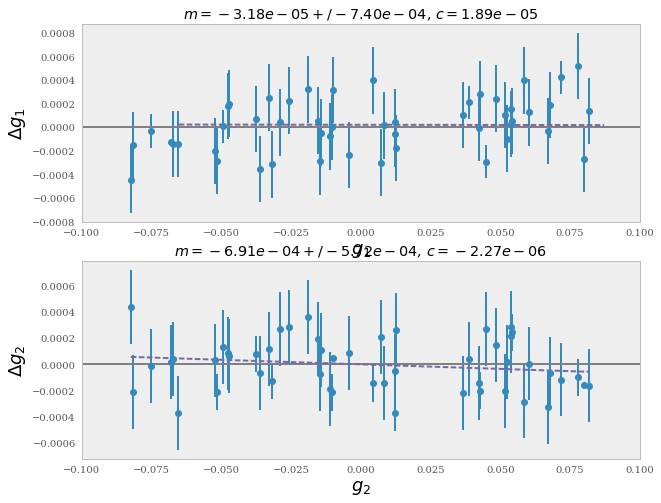

In [34]:
from scipy.stats import linregress

fig = plt.figure(figsize=(10, 8))

for i in xrange(2):
    slope, intercept, r_value, p_value, std_err = linregress(g_true[:, i], bias[:,0 + 2*i])
    xl = np.linspace(np.min(g_true[:, i]), np.max(g_true[:, i]), 50)

    plt.subplot(2, 1, i + 1)
    plt.errorbar(g_true[:, 1], bias[:, 0 + 2*i], yerr=bias[:, 1 + 2*i], fmt='o')
    plt.axhline(0., color='grey')
    plt.plot(xl, slope*xl + intercept, '--')
    plt.xlabel(r"$g_{:d}$".format(i + 1), fontsize=18)
    plt.ylabel(r"$\Delta g_{:d}$".format(i + 1), fontsize=18)
    plt.xlim(-0.1, 0.1)
    plt.title(r"$m = {:3.2e} +/- {:3.2e}$, $c = {:3.2e}$".format(slope, std_err, intercept))
plt.tight_layout()

## 2D ellipticity posterior comparison

Compare the gridded log-posterior of $e_1, e_2$ with contours from the Roaster MCMC chain.

In [151]:
ifield = 2
igal = 0
footprint_number = 0

roaster_outfile = "reaper/jif/{0:03d}/roaster_{0:03d}_seg{1:d}.h5".format(ifield, igal)
hfile = h5py.File(roaster_outfile, 'r')
grp = hfile['Samples/footprint{:d}'.format(footprint_number)]
paramnames = grp['post'].attrs['paramnames']
nparams = len(paramnames)
data = grp['post'][...]
logprob = grp['logprobs'][...]
hfile.close()

In [152]:
print data.shape
print paramnames

(1000, 30, 5)
['e1' 'e2' 'dx' 'dy']


In [153]:
e1 = data[:, :, 0].ravel()
e2 = data[:, :, 1].ravel()

In [154]:
from scipy import stats

true_shears, true_params = get_truths(ifield, igal)

de = 0.002
e1min = true_shears[0] - de
e1max = true_shears[0] + de
e2min = true_shears[1] - de
e2max = true_shears[1] + de

X, Y = np.mgrid[e1min:e1max:100j, e2min:e2max:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([e1, e2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

In [155]:
img = load_footprint(ifield, igal)
# -----
rstr = jiffy.Roaster("jiffy_bt1.yaml")
rstr.ngrid_x = nx
rstr.ngrid_y = ny
rstr.src_models[0].params[0].dx = true_params[0]
rstr.src_models[0].params[0].dy = true_params[1]
rstr.src_models[0].set_params(true_shears)
rstr.data = img
        
ngg = 20
shear1 = np.linspace(true_shears[0] - de, true_shears[0] + de, ngg)
shear2 = np.linspace(true_shears[1] - de, true_shears[1] + de, ngg)
g1, g2 = np.meshgrid(shear1, shear2)

lnp = np.zeros((ngg, ngg), dtype=np.float64)
for i in xrange(ngg):
    for j in xrange(ngg):
        lnp[i,j] = rstr([g1[i,j], g2[i,j]])

popt, _ = fit_gaussian((g1, g2), lnp)

[0.0008284029644935252, 0.00085729002037103919]
[ 0.0002828   0.00028271]


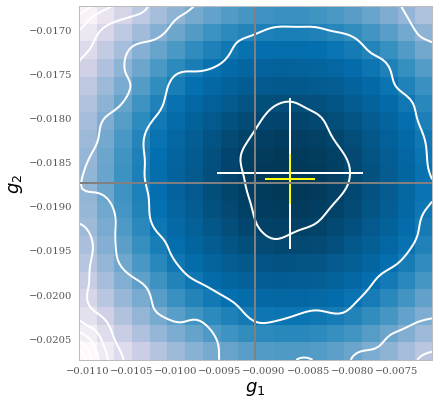

In [158]:
fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(111)
# ax.imshow(np.rot90(Z), cmap=plt.cm.viridis,
#            extent=[e1min, e1max, e2min, e2max])
ax.imshow(lnp, interpolation='none', origin='lower',
          cmap=plt.cm.PuBu,
          extent=[e1min, e1max, e2min, e2max])
ax.contour(X, Y, np.log(Z), 10, colors='white')
# ax.contour(g1, g2, np.exp(lnp))
# ax.plot(e1, e2, 'k.', markersize=2)
# ax.set_xlim([e1min, e1max])
# ax.set_ylim([e2min, e2max])

plt.axvline(true_shears[0], color='grey')
plt.axhline(true_shears[1], color='grey')

# plt.plot(np.mean(e1), np.mean(e2), 'o', markersize=12, color='red')
plt.errorbar(np.mean(e1), np.mean(e2), xerr=np.std(e1), yerr=np.std(e2), color='white')

# plt.plot(popt[1], popt[2], 'o', markersize=6, color='blue')
plt.errorbar(popt[1], popt[2], xerr=popt[3], yerr=popt[4], color='yellow')

print [np.std(e1), np.std(e2)]
print popt[3:5]

plt.xlabel(r"$g_1$", fontsize=18)
plt.ylabel(r"$g_2$", fontsize=18)

## Shear bias from Roaster outputs

In [181]:
bias = np.zeros((nfields, 4), dtype=np.float64)
g_true = np.zeros((nfields, 2), dtype=np.float64)
for ifield in xrange(nfields):
    print "--- Field {:d} / {:d} ---".format(ifield+1, nfields)
    for igal in xrange(ngals_per_field):
        roaster_outfile = "reaper/jif/{0:03d}/roaster_{0:03d}_seg{1:d}.h5".format(ifield, igal)
        hfile = h5py.File(roaster_outfile, 'r')
        grp = hfile['Samples/footprint{:d}'.format(igal)]
        paramnames = grp['post'].attrs['paramnames']
        nparams = len(paramnames)
        data = grp['post'][...]
        hfile.close()
        # -----
        e1 = data[:, :, 0].ravel()
        e2 = data[:, :, 1].ravel()
        # -----
        true_shears, true_params = get_truths(ifield, igal)
        g_true[ifield, 0] = true_shears[0]
        g_true[ifield, 1] = true_shears[1]
        # -----
        bias[ifield, 0] += np.mean(e1) - true_shears[0]
        bias[ifield, 1] += np.std(e1)
        bias[ifield, 2] += np.mean(e2) - true_shears[1]
        bias[ifield, 3] += np.std(e2)
    bias[ifield, :] /= ngals_per_field

--- Field 1 / 50 ---
--- Field 2 / 50 ---
--- Field 3 / 50 ---
--- Field 4 / 50 ---
--- Field 5 / 50 ---
--- Field 6 / 50 ---
--- Field 7 / 50 ---
--- Field 8 / 50 ---
--- Field 9 / 50 ---
--- Field 10 / 50 ---
--- Field 11 / 50 ---
--- Field 12 / 50 ---
--- Field 13 / 50 ---
--- Field 14 / 50 ---
--- Field 15 / 50 ---
--- Field 16 / 50 ---
--- Field 17 / 50 ---
--- Field 18 / 50 ---
--- Field 19 / 50 ---
--- Field 20 / 50 ---
--- Field 21 / 50 ---
--- Field 22 / 50 ---
--- Field 23 / 50 ---
--- Field 24 / 50 ---
--- Field 25 / 50 ---
--- Field 26 / 50 ---
--- Field 27 / 50 ---
--- Field 28 / 50 ---
--- Field 29 / 50 ---
--- Field 30 / 50 ---
--- Field 31 / 50 ---
--- Field 32 / 50 ---
--- Field 33 / 50 ---
--- Field 34 / 50 ---
--- Field 35 / 50 ---
--- Field 36 / 50 ---
--- Field 37 / 50 ---
--- Field 38 / 50 ---
--- Field 39 / 50 ---
--- Field 40 / 50 ---
--- Field 41 / 50 ---
--- Field 42 / 50 ---
--- Field 43 / 50 ---
--- Field 44 / 50 ---
--- Field 45 / 50 ---
--- Field 46 / 50 -

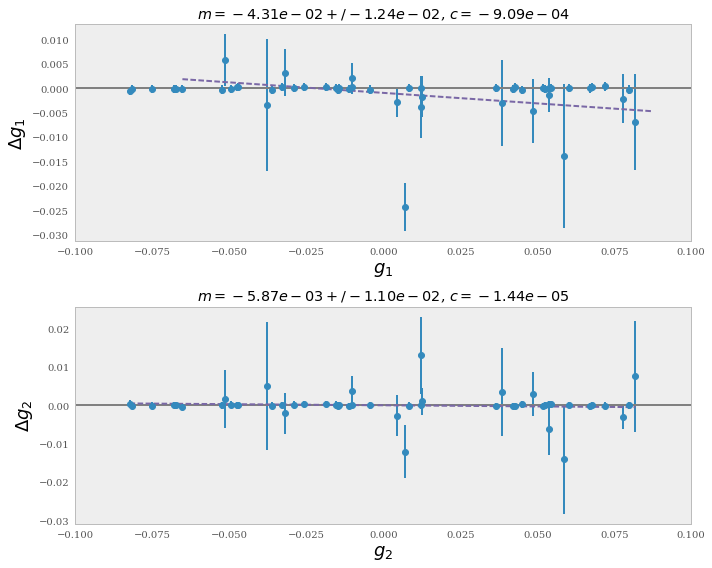

In [182]:
fig = plt.figure(figsize=(10, 8))

for i in xrange(2):
    slope, intercept, r_value, p_value, std_err = linregress(g_true[:, i], bias[:,0 + 2*i])
    xl = np.linspace(np.min(g_true[:, i]), np.max(g_true[:, i]), 50)

    plt.subplot(2, 1, i + 1)
    plt.errorbar(g_true[:, 1], bias[:, 0 + 2*i], yerr=bias[:, 1 + 2*i], fmt='o')
    plt.axhline(0., color='grey')
    plt.plot(xl, slope*xl + intercept, '--')
    plt.xlabel(r"$g_{:d}$".format(i + 1), fontsize=18)
    plt.ylabel(r"$\Delta g_{:d}$".format(i + 1), fontsize=18)
    plt.xlim(-0.1, 0.1)
    plt.title(r"$m = {:3.2e} +/- {:3.2e}$, $c = {:3.2e}$".format(slope, std_err, intercept))
plt.tight_layout()